In [20]:
import os  # To work with file system paths
import json  # To handle JSON files
from jiwer import wer, cer  # For calculating WER and CER
import matplotlib.pyplot as plt  # For plotting boxplots and trends
from scipy.stats import ttest_ind, mannwhitneyu, shapiro  # For statistical tests
import numpy as np  # For numerical operations
import pandas as pd  # For creating and managing DataFrames
import seaborn as sns  # For creating bar plots with error bars

def read_file(filepath: str) -> str:
    """Reads the content of a text file and returns it as a string."""
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read().strip()

def extract_id_from_filename(filename: str) -> str:
    """Extracts the patient ID from the filename using specific naming conventions."""
    if filename.startswith(('B1', 'B2')):
        patient_id = filename[2:].split('.')[0]
    elif filename.startswith(('FB1', 'PR1')):
        patient_id = filename[3:].split('.')[0]
    
    # Logic to extract ID based on the presence of two digits followed by 'F' or 'M'
    age_found = False
    for i in range(len(patient_id)):
        if patient_id[i].isdigit() and not age_found:
            if i + 1 < len(patient_id) and patient_id[i+1].isdigit():
                age_found = True
        elif age_found and patient_id[i] in ['F', 'M']:
            patient_id = patient_id[:i+1]
            break
    return patient_id

def load_json_data(json_filepath: str):
    """Loads data from a JSON file and returns it as a dictionary."""
    with open(json_filepath, 'r', encoding='utf-8') as file:
        return json.load(file)

def determine_group_and_task(file_id: str, json_data) -> tuple:
    """Determines the group (control or Parkinsonian) and task associated with a file."""
    for entry in json_data:
        if entry['id'] == file_id:
            group = 'control' if entry['label'] == 0 else 'parkinson'
            task = entry['task'].replace(' ', '').lower()
            updrs = entry.get('UPDRS', None)
            return group, task, updrs
    return 'unknown', 'unknown', None

def calculate_wer_cer_for_groups(directory: str, json_filepath: str, reference_texts) -> dict:
    """Calculates WER and CER for control and Parkinsonian groups."""
    try:
        json_data = load_json_data(json_filepath)
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return {}
    
    control_wer, parkinsonian_wer = [], []
    control_cer, parkinsonian_cer = [], []
    parkinsonian_wer_by_updrs = {i: [] for i in range(5)}
    parkinsonian_cer_by_updrs = {i: [] for i in range(5)}
    control_files_count, parkinsonian_files_count = 0, 0
    updrs_files_count = {i: 0 for i in range(5)}
    
    files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    
    for file in files:
        file_id = extract_id_from_filename(file)
        if file_id is None:
            print(f"ID not recognized for file '{file}'")
            continue
        
        group, task, updrs = determine_group_and_task(file_id, json_data)
        if group == 'unknown' or task == 'unknown':
            print(f"ID or task not recognized for file '{file}'")
            continue
        
        if task not in reference_texts:
            print(f"Task '{task}' not recognized in file '{file}'")
            continue
        
        file_path = os.path.join(directory, file)
        reference = reference_texts[task]
        hypothesis = read_file(file_path)
        
        # Calculate WER and CER using the jiwer library
        wer_value = wer(reference, hypothesis)
        cer_value = cer(reference, hypothesis)
        
        # Add WER and CER to the appropriate lists and increment counters
        if group == 'control':
            control_wer.append(wer_value)
            control_cer.append(cer_value)
            control_files_count += 1
        elif group == 'parkinson':
            parkinsonian_wer.append(wer_value)
            parkinsonian_cer.append(cer_value)
            parkinsonian_files_count += 1
            if updrs is not None:
                parkinsonian_wer_by_updrs[updrs].append(wer_value)
                parkinsonian_cer_by_updrs[updrs].append(cer_value)
                updrs_files_count[updrs] += 1
    
    print(f"Number of control files processed: {control_files_count}")
    print(f"Number of Parkinsonian files processed: {parkinsonian_files_count}")
    
    return {
        'control_wer': control_wer,
        'parkinsonian_wer': parkinsonian_wer,
        'control_cer': control_cer,
        'parkinsonian_cer': parkinsonian_cer,
        'control_files_count': control_files_count,
        'parkinsonian_files_count': parkinsonian_files_count,
        'updrs_files_count': updrs_files_count,
        'parkinsonian_wer_by_updrs': parkinsonian_wer_by_updrs,
        'parkinsonian_cer_by_updrs': parkinsonian_cer_by_updrs
    }


def remove_outliers_iqr(data):
    """Removes outliers using Tukey's IQR method and returns the clean data along with the outliers."""
    q1 = np.percentile(data, 25)  # First quartile (Q1)
    q3 = np.percentile(data, 75)  # Third quartile (Q3)
    iqr = q3 - q1  # Interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower bound
    upper_bound = q3 + 1.5 * iqr  # Calculate upper bound
    
    # Print bounds for debugging
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    
    # Separate data into clean data and outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    
    # Print number and values of outliers for debugging
    print(f"Number of outliers detected: {len(outliers)}")
    print(f"Outliers: {outliers}")
    
    return filtered_data, outliers




In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Section 6: Plotting the Boxplots (WER and CER) Separately with Larger Text and Legend, Including Numerosity and Outliers
def plot_boxplots_wer_cer(control_wer, parkinsonian_wer, control_cer, parkinsonian_cer):
    """Plots separate boxplots for WER and CER with Tukey's outlier removal, showing numerosity and outliers with larger text."""
    
    # Print numerosity before outlier removal
    print(f"\n### Numerosity Before Outlier Removal ###")
    print(f"WER - Control group: {len(control_wer)}, Parkinsonian group: {len(parkinsonian_wer)}")
    print(f"CER - Control group: {len(control_cer)}, Parkinsonian group: {len(parkinsonian_cer)}")
    
    # Calculate and print medians and means before outlier removal
    median_control_wer = np.median(control_wer)
    median_parkinsonian_wer = np.median(parkinsonian_wer)
    median_control_cer = np.median(control_cer)
    median_parkinsonian_cer = np.median(parkinsonian_cer)
    
    mean_control_wer = np.mean(control_wer)
    mean_parkinsonian_wer = np.mean(parkinsonian_wer)
    mean_control_cer = np.mean(control_cer)
    mean_parkinsonian_cer = np.mean(parkinsonian_cer)
    
    print(f"\n### Medians and Means ###")
    print(f"WER - Control group median: {median_control_wer:.4f}, mean: {mean_control_wer:.4f}")
    print(f"WER - Parkinsonian group median: {median_parkinsonian_wer:.4f}, mean: {mean_parkinsonian_wer:.4f}")
    print(f"CER - Control group median: {median_control_cer:.4f}, mean: {mean_control_cer:.4f}")
    print(f"CER - Parkinsonian group median: {median_parkinsonian_cer:.4f}, mean: {mean_parkinsonian_cer:.4f}")
    
    # Remove outliers using Tukey's method
    control_wer_clean, control_wer_outliers = remove_outliers_iqr(control_wer)
    parkinsonian_wer_clean, parkinsonian_wer_outliers = remove_outliers_iqr(parkinsonian_wer)
    control_cer_clean, control_cer_outliers = remove_outliers_iqr(control_cer)
    parkinsonian_cer_clean, parkinsonian_cer_outliers = remove_outliers_iqr(parkinsonian_cer)
    
    # Print numerosity after outlier removal
    print(f"\n### Numerosity After Outlier Removal ###")
    print(f"WER - Control group: {len(control_wer_clean)}, Parkinsonian group: {len(parkinsonian_wer_clean)}")
    print(f"CER - Control group: {len(control_cer_clean)}, Parkinsonian group: {len(parkinsonian_cer_clean)}")
    
    # Calculate and print medians for debugging
    median_control_wer_clean = np.median(control_wer_clean)
    median_parkinsonian_wer_clean = np.median(parkinsonian_wer_clean)
    median_control_cer_clean = np.median(control_cer_clean)
    median_parkinsonian_cer_clean = np.median(parkinsonian_cer_clean)
    
    # Boxplot for WER (separate figure)
    plt.figure(figsize=(8, 6))
    plt.boxplot([control_wer_clean, parkinsonian_wer_clean], patch_artist=True, showmeans=True, meanline=True, 
                labels=['Controls', 'Parkinsonians'], 
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                meanprops=dict(color='green', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
    
    # Manually plot outliers as black dots
    for i, outliers in enumerate([control_wer_outliers, parkinsonian_wer_outliers], start=1):
        plt.scatter([i] * len(outliers), outliers, color='black', zorder=3)
    
    # Add title and labels for WER
    plt.title('WER Distribution for Controls and Parkinsonians (Bari)', fontsize=16)
    plt.ylabel('WER', fontsize=14)
    plt.xticks(fontsize=12)  # X-axis label size
    plt.yticks(fontsize=12)  # Y-axis label size
    
    # Add custom legend for Mean and Median
    handles = [plt.Line2D([0], [0], color='green', label='Mean', linestyle='-'),
               plt.Line2D([0], [0], color='red', label='Median', linestyle='-')]
    plt.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    
    # Show the WER plot
    plt.tight_layout()
    plt.show()
    
    # Boxplot for CER (separate figure)
    plt.figure(figsize=(8, 6))
    plt.boxplot([control_cer_clean, parkinsonian_cer_clean], patch_artist=True, showmeans=True, meanline=True, 
                labels=['Controls', 'Parkinsonians'], 
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                meanprops=dict(color='green', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
    
    # Manually plot outliers as black dots
    for i, outliers in enumerate([control_cer_outliers, parkinsonian_cer_outliers], start=1):
        plt.scatter([i] * len(outliers), outliers, color='black', zorder=3)
    
    # Add title and labels for CER
    plt.title('CER Distribution for Controls and Parkinsonians (Bari)', fontsize=16)
    plt.ylabel('CER', fontsize=14)
    plt.xticks(fontsize=12)  # X-axis label size
    plt.yticks(fontsize=12)  # Y-axis label size
    
    # Add custom legend for Mean and Median
    plt.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    
    # Show the CER plot
    plt.tight_layout()
    plt.show()




In [22]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

def summary_statistics(control_wer_raw, parkinsonian_wer_raw, control_wer_clean, parkinsonian_wer_clean,
                       control_cer_raw, parkinsonian_cer_raw, control_cer_clean, parkinsonian_cer_clean,
                       output_filename="cumulative_results_Bari.csv"):
    """
    Calculates and saves the summary statistics (mean, median, standard deviation) for WER and CER 
    for controls and Parkinsonians using raw data. Uses cleaned data for normality and significance tests.
    
    Parameters:
    - control_wer_raw: List of raw WER values for the control group
    - parkinsonian_wer_raw: List of raw WER values for the Parkinsonians group
    - control_wer_clean: Cleaned list of WER values for the control group
    - parkinsonian_wer_clean: Cleaned list of WER values for the Parkinsonians group
    - control_cer_raw: List of raw CER values for the control group
    - parkinsonian_cer_raw: List of raw CER values for the Parkinsonians group
    - control_cer_clean: Cleaned list of CER values for the control group
    - parkinsonian_cer_clean: Cleaned list of CER values for the Parkinsonians group
    - output_filename: Name of the output CSV file to save the summary table
    """
    
    # Calculate number of outliers
    wer_outliers_control = len(control_wer_raw) - len(control_wer_clean)
    wer_outliers_parkinsonian = len(parkinsonian_wer_raw) - len(parkinsonian_wer_clean)
    cer_outliers_control = len(control_cer_raw) - len(control_cer_clean)
    cer_outliers_parkinsonian = len(parkinsonian_cer_raw) - len(parkinsonian_cer_clean)
    
    # Display number of outliers for each group
    print("\n### Number of Outliers ###")
    print(f"WER - Control group: {wer_outliers_control}, Parkinsonian group: {wer_outliers_parkinsonian}")
    print(f"CER - Control group: {cer_outliers_control}, Parkinsonian group: {cer_outliers_parkinsonian}")
    
    # Summary statistics for WER using raw data
    wer_stats = {
        'Group': ['Control', 'Parkinsonians'],
        'WER Mean': [np.mean(control_wer_raw), np.mean(parkinsonian_wer_raw)],
        'WER Median': [np.median(control_wer_raw), np.median(parkinsonian_wer_raw)],
        'WER Std Dev': [np.std(control_wer_raw, ddof=1), np.std(parkinsonian_wer_raw, ddof=1)]
    }
    
    # Summary statistics for CER using raw data
    cer_stats = {
        'Group': ['Control', 'Parkinsonians'],
        'CER Mean': [np.mean(control_cer_raw), np.mean(parkinsonian_cer_raw)],
        'CER Median': [np.median(control_cer_raw), np.median(parkinsonian_cer_raw)],
        'CER Std Dev': [np.std(control_cer_raw, ddof=1), np.std(parkinsonian_cer_raw, ddof=1)]
    }
    
    # Create DataFrames for WER and CER statistics
    wer_df = pd.DataFrame(wer_stats)
    cer_df = pd.DataFrame(cer_stats)
    
    # Combine WER and CER statistics into a single DataFrame
    summary_df = pd.concat([wer_df, cer_df.drop(columns='Group')], axis=1)
    
    # Save the summary statistics to a CSV file
    summary_df.to_csv(output_filename, index=False)
    
    print(f"\n### Summary Statistics for WER and CER saved to {output_filename} ###")
    print(summary_df)
    
    # Statistical tests between control and Parkinsonians for WER and CER using cleaned data
    print("\n### Statistical Tests ###")
    
    # Shapiro-Wilk test for normality on cleaned data
    wer_normality_control = shapiro(control_wer_clean)[1]
    wer_normality_parkinsonian = shapiro(parkinsonian_wer_clean)[1]
    cer_normality_control = shapiro(control_cer_clean)[1]
    cer_normality_parkinsonian = shapiro(parkinsonian_cer_clean)[1]
    
    print("\nShapiro-Wilk p-values (Normality Test on Cleaned Data):")
    print(f"Control WER: {wer_normality_control}")
    print(f"Parkinsonians WER: {wer_normality_parkinsonian}")
    print(f"Control CER: {cer_normality_control}")
    print(f"Parkinsonians CER: {cer_normality_parkinsonian}")
    
    # Decide on parametric (t-test) or non-parametric test (Mann-Whitney U) based on normality
    if wer_normality_control > 0.05 and wer_normality_parkinsonian > 0.05:
        # Parametric t-test for WER
        wer_test_stat, wer_p_value = ttest_ind(control_wer_clean, parkinsonian_wer_clean)
        wer_test_name = "t-test"
    else:
        # Non-parametric Mann-Whitney U test for WER
        wer_test_stat, wer_p_value = mannwhitneyu(control_wer_clean, parkinsonian_wer_clean, alternative='two-sided')
        wer_test_name = "Mann-Whitney U"
        
    if cer_normality_control > 0.05 and cer_normality_parkinsonian > 0.05:
        # Parametric t-test for CER
        cer_test_stat, cer_p_value = ttest_ind(control_cer_clean, parkinsonian_cer_clean)
        cer_test_name = "t-test"
    else:
        # Non-parametric Mann-Whitney U test for CER
        cer_test_stat, cer_p_value = mannwhitneyu(control_cer_clean, parkinsonian_cer_clean, alternative='two-sided')
        cer_test_name = "Mann-Whitney U"
    
    # Display results of the tests
    print(f"\nWER Statistical Test ({wer_test_name}): Statistic = {wer_test_stat}, p-value = {wer_p_value}")
    print(f"CER Statistical Test ({cer_test_name}): Statistic = {cer_test_stat}, p-value = {cer_p_value}")
    
    # Adding test results to summary DataFrame
    test_results = {
        'Metric': ['WER', 'CER'],
        'Test': [wer_test_name, cer_test_name],
        'Test Statistic': [wer_test_stat, cer_test_stat],
        'p-value': [wer_p_value, cer_p_value]
    }
    test_df = pd.DataFrame(test_results)
    
    # Save test results to CSV file
    with open(output_filename, 'a') as f:
        f.write("\n\n### Statistical Test Results ###\n")
        test_df.to_csv(f, index=False)
    
    print("\n### Statistical Test Results saved to CSV ###")
    print(test_df)
    
    return summary_df, test_df


from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Section 4: Perform Statistical Tests (Shapiro-Wilk, Mann-Whitney U, or t-test)
def perform_statistical_tests(control_values, parkinsonian_values, metric_name):
    """Performs Shapiro-Wilk test for normality and applies the appropriate statistical test."""

    # Shapiro-Wilk test for normality
    control_normality_p = shapiro(control_values).pvalue
    parkinsonian_normality_p = shapiro(parkinsonian_values).pvalue
    
    # Debug information about normality
    print(f"\n### Debug for {metric_name} ###")
    print(f"{metric_name} - Control group normality p-value: {control_normality_p:.3e}")
    print(f"{metric_name} - Parkinsonian group normality p-value: {parkinsonian_normality_p:.3e}")
    
    alpha = 0.05  # Significance level
    
    # Determine if both groups are normally distributed
    if control_normality_p > alpha and parkinsonian_normality_p > alpha:
        print(f"The p-value for normality is greater than {alpha}, so both groups are normally distributed for {metric_name}. Performing unpaired t-test.")
        stat, p_value = ttest_ind(control_values, parkinsonian_values)
        print(f"The p-value for the unpaired t-test is {p_value:.3e}.")
    else:
        print(f"At least one group is not normally distributed for {metric_name} (p-value <= {alpha}). Performing Mann-Whitney U test.")
        stat, p_value = mannwhitneyu(control_values, parkinsonian_values)
        print(f"The p-value for the Mann-Whitney U test is {p_value:.3e}.")
    
    # Debugging result interpretation
    if p_value < alpha:
        print(f"Since the p-value is less than {alpha}, we reject the null hypothesis. There is a statistically significant difference between the two groups for {metric_name}.")
    else:
        print(f"Since the p-value is greater than {alpha}, we fail to reject the null hypothesis. There is no statistically significant difference between the two groups for {metric_name}.")
    
    return p_value


Number of control files processed: 130
Number of Parkinsonian files processed: 106
Lower bound: -0.5478515625, Upper bound: 1.9130859375
Number of outliers detected: 0
Outliers: []
Lower bound: -0.38671875, Upper bound: 1.81640625
Number of outliers detected: 1
Outliers: [1.875]
Lower bound: -0.8020833333333335, Upper bound: 1.6759868421052633
Number of outliers detected: 0
Outliers: []
Lower bound: -0.7235014619883042, Upper bound: 1.6405336257309941
Number of outliers detected: 0
Outliers: []
Lower bound: -0.3486328125, Upper bound: 1.7685546875
Number of outliers detected: 0
Outliers: []
Lower bound: -0.55859375, Upper bound: 1.91015625
Number of outliers detected: 0
Outliers: []
Lower bound: -0.1865234375, Upper bound: 1.7119140625
Number of outliers detected: 0
Outliers: []
Lower bound: 0.6875, Upper bound: 1.15625
Number of outliers detected: 0
Outliers: []
Lower bound: 0.8525390625, Upper bound: 1.0478515625
Number of outliers detected: 0
Outliers: []
Lower bound: -0.71765350877

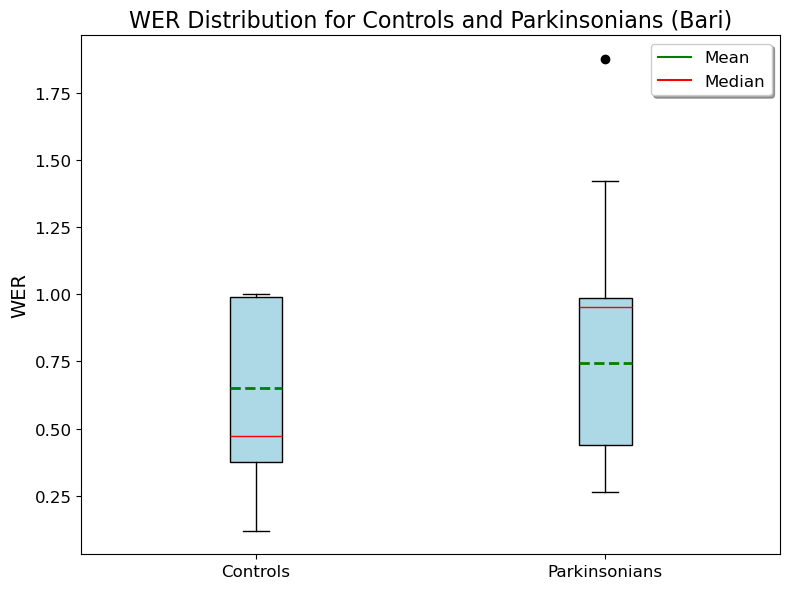

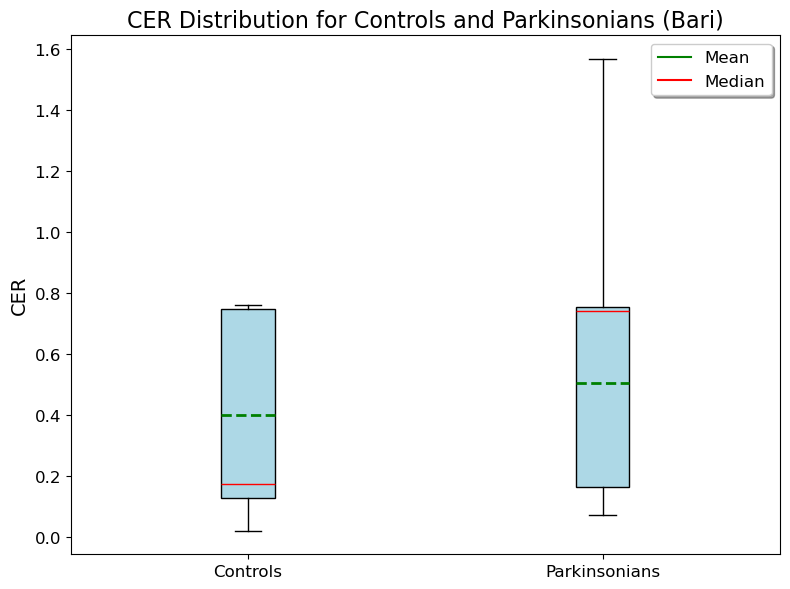

In [23]:
import os
import json
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Directory and JSON filepath
directory = 'dati'  # Directory where the data files are located
json_filepath = 'DIMAURO_new.json'  # JSON file in the same directory as the script

# Reference texts associated with tasks
reference_texts = {
    'readtext': 'Il ramarro della zia. Il papà (o il babbo come dice il piccolo Dado) era sul letto. Sotto di lui, accanto al lago, sedeva Gigi, detto Ciccio, cocco della mamma e della nonna. Vicino ad un sasso c’era una rosa rosso vivo e lo sciocco, vedendola, la volle per la zia. La zia Lulù cercava zanzare per il suo ramarro, ma dato che era giugno (o luglio non so bene) non ne trovava. Trovò invece una rana che saltando dalla strada finì nel lago con un grande spruzzo. Sai che fifa, la zia! Lo schizzo bagnò il suo completo rosa che divenne giallo come un taxi. Passava di lì un signore cosmopolita di nome Sardanapalo Nabucodonosor che si innamorò della zia e la portò con sé in Afghanistan.',
    'words': 'pipa, buco, topo, dado, casa, gatto, filo, vaso, muro, neve, luna, rete, zero, scia, ciao, giro, sole, uomo, iuta, gnomo, glielo, pozzo, brodo, plagio, treno, classe, grigio, flotta, creta, drago, frate, spesa, stufa, scala, slitta, splende, strada, scrive, spruzzo, sgrido, sfregio, sdraio, sbrigo, prova, calendario, autobiografia, monotono, pericoloso, montagnoso, prestigioso.',
    'phrases': 'Oggi è una bella giornata per sciare. Voglio una maglia di lana color ocra. Il motociclista attraversò una strada stretta di montagna. Patrizia ha pranzato a casa di Fabio. Questo è il tuo cappello? Dopo vieni a casa? La televisione funziona? Non posso aiutarti? Marco non è partito. Il medico non è impegnato.'
}

# Step 1: Calculate WER and CER
results = calculate_wer_cer_for_groups(directory, json_filepath, reference_texts)

# Estrarre dati grezzi per WER e CER per gruppi di controllo e parkinsoniani
control_wer = results['control_wer']
parkinsonian_wer = results['parkinsonian_wer']
control_cer = results['control_cer']
parkinsonian_cer = results['parkinsonian_cer']
parkinsonian_wer_by_updrs = results['parkinsonian_wer_by_updrs']
parkinsonian_cer_by_updrs = results['parkinsonian_cer_by_updrs']

# Applicare la funzione di rimozione degli outliers ai dati grezzi
control_wer_clean, control_wer_outliers = remove_outliers_iqr(control_wer)
parkinsonian_wer_clean, parkinsonian_wer_outliers = remove_outliers_iqr(parkinsonian_wer)
control_cer_clean, control_cer_outliers = remove_outliers_iqr(control_cer)
parkinsonian_cer_clean, parkinsonian_cer_outliers = remove_outliers_iqr(parkinsonian_cer)
parkinsonian_wer_by_updrs_clean = {i: remove_outliers_iqr(parkinsonian_wer_by_updrs[i])[0] for i in range(5)}
parkinsonian_cer_by_updrs_clean = {i: remove_outliers_iqr(parkinsonian_cer_by_updrs[i])[0] for i in range(5)}

# Stampare informazioni sugli outliers
print("\n### Informazioni sugli outlier per ogni gruppo ###")
print(f"Control WER - Outliers ({len(control_wer_outliers)}): {control_wer_outliers}")
print(f"Control CER - Outliers ({len(control_cer_outliers)}): {control_cer_outliers}")
print(f"Parkinsonian WER - Outliers ({len(parkinsonian_wer_outliers)}): {parkinsonian_wer_outliers}")
print(f"Parkinsonian CER - Outliers ({len(parkinsonian_cer_outliers)}): {parkinsonian_cer_outliers}")

# Outlier per ogni livello di UPDRS
for updrs_level in range(5):
    wer_clean, wer_outliers = remove_outliers_iqr(parkinsonian_wer_by_updrs[updrs_level])
    cer_clean, cer_outliers = remove_outliers_iqr(parkinsonian_cer_by_updrs[updrs_level])
    print(f"UPDRS {updrs_level} WER - Outliers ({len(wer_outliers)}): {wer_outliers}")
    print(f"UPDRS {updrs_level} CER - Outliers ({len(cer_outliers)}): {cer_outliers}")

# Step 2: Plotting boxplots per WER e CER, utilizzando i dati grezzi
plot_boxplots_wer_cer(control_wer, parkinsonian_wer, control_cer, parkinsonian_cer)



In [24]:
# Compute summary statistics for raw data and run statistical tests on cleaned data
# Use `summary_statistics` to calculate mean, median, and standard deviation on raw data,
# and to perform statistical tests on cleaned data.

# Run the `summary_statistics` function on raw (raw) and cleaned (clean) data
summary_stats_df, test_results_df = summary_statistics(
    control_wer_raw=control_wer,                  # Raw WER values for controls
    parkinsonian_wer_raw=parkinsonian_wer,        # Raw WER values for Parkinsonians
    control_wer_clean=control_wer_clean,          # Cleaned WER values for controls
    parkinsonian_wer_clean=parkinsonian_wer_clean,# Cleaned WER values for Parkinsonians
    control_cer_raw=control_cer,                  # Raw CER values for controls
    parkinsonian_cer_raw=parkinsonian_cer,        # Raw CER values for Parkinsonians
    control_cer_clean=control_cer_clean,          # Cleaned CER values for controls
    parkinsonian_cer_clean=parkinsonian_cer_clean # Cleaned CER values for Parkinsonians
)

# Perform separate statistical tests for WER and CER using cleaned data
wer_test_summary = perform_statistical_tests(control_wer_clean, parkinsonian_wer_clean, "WER")
cer_test_summary = perform_statistical_tests(control_cer_clean, parkinsonian_cer_clean, "CER")

# Combine test results into a DataFrame to save to file
test_summary_df = pd.DataFrame([wer_test_summary, cer_test_summary])

# Save cumulative summary statistics and test results to a single CSV file
output_filename = "cumulative_results_Bari.csv"
summary_stats_df.to_csv(output_filename, index=False)
with open(output_filename, 'a') as f:
    f.write("\n\n### Test Summary Results ###\n")
    test_summary_df.to_csv(f, index=False)

print("\n### Summary Statistics ###")
print(summary_stats_df)
print("\n### Test Results ###")
print(test_summary_df)



### Number of Outliers ###
WER - Control group: 0, Parkinsonian group: 1
CER - Control group: 0, Parkinsonian group: 0

### Summary Statistics for WER and CER saved to cumulative_results_Bari.csv ###
           Group  WER Mean  WER Median  WER Std Dev  CER Mean  CER Median  \
0        Control  0.649803    0.472656     0.299084  0.400322    0.175439   
1  Parkinsonians  0.753390    0.953125     0.310601  0.504427    0.739766   

   CER Std Dev  
0     0.306244  
1     0.323023  

### Statistical Tests ###

Shapiro-Wilk p-values (Normality Test on Cleaned Data):
Control WER: 5.106659261362855e-13
Parkinsonians WER: 7.856777854920162e-10
Control CER: 4.882314024751746e-15
Parkinsonians CER: 1.1341171117412034e-10

WER Statistical Test (Mann-Whitney U): Statistic = 5827.5, p-value = 0.052730505272756516
CER Statistical Test (Mann-Whitney U): Statistic = 5330.5, p-value = 0.0027963973640919943

### Statistical Test Results saved to CSV ###
  Metric            Test  Test Statistic   p-value

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, kruskal
from scikit_posthocs import posthoc_dunn

def summary_statistics_and_tests_dimauro(control_wer_clean, parkinsonian_wer_by_updrs_clean,
                                         control_cer_clean, parkinsonian_cer_by_updrs_clean,
                                         output_filename="summary_statistics_and_tests_dimauro.csv", alpha=0.05):
    """
    Calculates summary statistics for WER and CER across Control and all UPDRS groups (0-4), performs normality tests, 
    applies Kruskal-Wallis across all groups, and if significant, performs Dunn's post hoc test without Bonferroni correction.
    Results are saved to a CSV file.
    """
    
    # Define group labels for display purposes
    updrs_levels = ['Control'] + [f'UPDRS {i}' for i in range(5)]
    
    # Convert UPDRS group data from dictionaries to lists for analysis
    parkinsonian_wer_by_updrs_list = [parkinsonian_wer_by_updrs_clean[i] for i in range(5)]
    parkinsonian_cer_by_updrs_list = [parkinsonian_cer_by_updrs_clean[i] for i in range(5)]
    
    # Step 1: Display sample sizes with additional detail
    print("\n### Group Sizes (Sample Counts) ###")
    sample_sizes = {'Group': updrs_levels, 'Sample Size': [len(control_wer_clean)] + [len(parkinsonian_wer_by_updrs_list[i]) for i in range(5)]}
    sample_df = pd.DataFrame(sample_sizes)
    print(sample_df.to_string(index=False))
    
    # Step 2: Calculate and display summary statistics for WER and CER
    wer_stats = {
        'Group': updrs_levels,
        'WER Mean': [np.mean(control_wer_clean)] + [np.mean(parkinsonian_wer_by_updrs_list[i]) for i in range(5)],
        'WER Median': [np.median(control_wer_clean)] + [np.median(parkinsonian_wer_by_updrs_list[i]) for i in range(5)],
        'WER Std Dev': [np.std(control_wer_clean, ddof=1)] + [np.std(parkinsonian_wer_by_updrs_list[i], ddof=1) for i in range(5)]
    }
    cer_stats = {
        'Group': updrs_levels,
        'CER Mean': [np.mean(control_cer_clean)] + [np.mean(parkinsonian_cer_by_updrs_list[i]) for i in range(5)],
        'CER Median': [np.median(control_cer_clean)] + [np.median(parkinsonian_cer_by_updrs_list[i]) for i in range(5)],
        'CER Std Dev': [np.std(control_cer_clean, ddof=1)] + [np.std(parkinsonian_cer_by_updrs_list[i], ddof=1) for i in range(5)]
    }

    wer_df = pd.DataFrame(wer_stats)
    cer_df = pd.DataFrame(cer_stats)
    
    print("\n### WER Summary Statistics ###")
    print(wer_df.to_string(index=False))
    print("\n### CER Summary Statistics ###")
    print(cer_df.to_string(index=False))
    
    with open(output_filename, 'w') as f:
        wer_df.to_csv(f, index=False)
        f.write("\n\n")
        cer_df.to_csv(f, index=False)
    
    # Step 3: Perform Shapiro-Wilk normality test and display results in a clean format
    print("\n### Shapiro-Wilk Normality Test Results ###")
    normality_results = {'Group': [], 'WER p-value': [], 'CER p-value': []}
    
    groups = [control_wer_clean] + parkinsonian_wer_by_updrs_list
    cer_groups = [control_cer_clean] + parkinsonian_cer_by_updrs_list

    for i, (wer_group, cer_group) in enumerate(zip(groups, cer_groups)):
        group_name = updrs_levels[i]
        wer_p_value = shapiro(wer_group).pvalue if len(wer_group) > 2 else np.nan
        cer_p_value = shapiro(cer_group).pvalue if len(cer_group) > 2 else np.nan
        normality_results['Group'].append(group_name)
        normality_results['WER p-value'].append(wer_p_value)
        normality_results['CER p-value'].append(cer_p_value)
        # Additional print for normality test interpretation
        print(f"For WER, {group_name} {'has' if wer_p_value > alpha else 'does not have'} a normal distribution (p-value = {wer_p_value:.4f})")
        print(f"For CER, {group_name} {'has' if cer_p_value > alpha else 'does not have'} a normal distribution (p-value = {cer_p_value:.4f})")
    
    normality_df = pd.DataFrame(normality_results)
    print("\n### Shapiro-Wilk Normality Test Results Summary ###")
    print(normality_df.to_string(index=False))
    
    with open(output_filename, 'a') as f:
        f.write("\n\n### Shapiro-Wilk Normality Test Results ###\n")
        normality_df.to_csv(f, index=False)
    
    # Step 4: Kruskal-Wallis test and, if necessary, Dunn's test with detailed interpretation
    significant_tests = {'Metric': [], 'Test': [], 'p-value': [], 'Conclusion': []}
    dunn_results = []

    # WER Kruskal-Wallis test
    print("\n### Kruskal-Wallis Test for WER ###")
    wer_stat, wer_p_value = kruskal(*groups)
    wer_conclusion = f"The difference is {'statistically significant' if wer_p_value < alpha else 'not statistically significant'} at alpha = {alpha}."
    significant_tests['Metric'].append('WER')
    significant_tests['Test'].append("Kruskal-Wallis")
    significant_tests['p-value'].append(wer_p_value)
    significant_tests['Conclusion'].append(wer_conclusion)
    print(f"Kruskal-Wallis WER p-value: {wer_p_value:.5f} - {wer_conclusion}")

    # CER Kruskal-Wallis test
    print("\n### Kruskal-Wallis Test for CER ###")
    cer_stat, cer_p_value = kruskal(*cer_groups)
    cer_conclusion = f"The difference is {'statistically significant' if cer_p_value < alpha else 'not statistically significant'} at alpha = {alpha}."
    significant_tests['Metric'].append('CER')
    significant_tests['Test'].append("Kruskal-Wallis")
    significant_tests['p-value'].append(cer_p_value)
    significant_tests['Conclusion'].append(cer_conclusion)
    print(f"Kruskal-Wallis CER p-value: {cer_p_value:.5f} - {cer_conclusion}")

    # Dunn's post hoc test for CER only if Kruskal-Wallis was significant
    if cer_p_value < alpha:
        print("\n### Dunn's Post Hoc Test for CER ###")
        dunn_test_results = posthoc_dunn(cer_groups)
        dunn_results.append(('CER', dunn_test_results))
        print("Dunn's post hoc test results for CER:\n", dunn_test_results)
        
        # Interpret Dunn's test results in detail
        print("\nInterpreting Dunn's Test Results for each UPDRS pair for CER:")
        for i, group_1 in enumerate(updrs_levels, 1):
            for j, group_2 in enumerate(updrs_levels, 1):
                if i < j:  # Print only unique pairs
                    p_value = dunn_test_results.iloc[i-1, j-1]
                    significance = "significantly different" if p_value < alpha else "not significantly different"
                    print(f"{group_1} vs. {group_2}: {significance} (p-value = {p_value:.4f})")
    
    # Convert significance test results to DataFrame and save
    tests_df = pd.DataFrame(significant_tests)
    with open(output_filename, 'a') as f:
        f.write("\n\n### Significance Test Results ###\n")
        tests_df.to_csv(f, index=False)
        
        # Save Dunn's test results for CER, if available
        if dunn_results:
            for metric, result in dunn_results:
                f.write(f"\n\n### Dunn's Post Hoc Test Results for {metric} ###\n")
                result.to_csv(f)
                print(f"Dunn's post hoc test results for {metric} saved to CSV.")

    # Display summaries in console
    print("\n### Summary Statistics and Test Results Saved to CSV ###")
    print("\n### Significance Test Summary ###")
    print(tests_df)

    if dunn_results:
        for metric, result in dunn_results:
            print(f"\n### Dunn's Post Hoc Test Results for {metric} ###")
            print(result.to_string(index=False))
    
    return wer_df, cer_df, normality_df, tests_df, dunn_results




In [26]:
# Execute the statistical analysis and store the results
wer_df, cer_df, normality_df, tests_df, dunn_results = summary_statistics_and_tests_dimauro(
    control_wer_clean,               # Cleaned WER values for Control group
    parkinsonian_wer_by_updrs_clean,  # Cleaned WER values for Parkinsonian UPDRS groups
    control_cer_clean,                # Cleaned CER values for Control group
    parkinsonian_cer_by_updrs_clean,  # Cleaned CER values for Parkinsonian UPDRS groups
    output_filename="bari_analysis_results.csv",  # Output filename for CSV
    alpha=0.05  # Significance level
)




### Group Sizes (Sample Counts) ###
  Group  Sample Size
Control          130
UPDRS 0           44
UPDRS 1           35
UPDRS 2           20
UPDRS 3            3
UPDRS 4            4

### WER Summary Statistics ###
  Group  WER Mean  WER Median  WER Std Dev
Control  0.649803    0.472656     0.299084
UPDRS 0  0.720170    0.835938     0.273010
UPDRS 1  0.727679    0.960938     0.366175
UPDRS 2  0.808594    0.953125     0.321903
UPDRS 3  0.908854    0.960938     0.125568
UPDRS 4  0.951172    0.949219     0.035730

### CER Summary Statistics ###
  Group  CER Mean  CER Median  CER Std Dev
Control  0.400322    0.175439     0.306244
UPDRS 0  0.461922    0.535819     0.295123
UPDRS 1  0.485505    0.739766     0.338591
UPDRS 2  0.571345    0.743421     0.385503
UPDRS 3  0.666179    0.761696     0.174377
UPDRS 4  0.681652    0.690789     0.119516

### Shapiro-Wilk Normality Test Results ###
For WER, Control does not have a normal distribution (p-value = 0.0000)
For CER, Control does not have a 

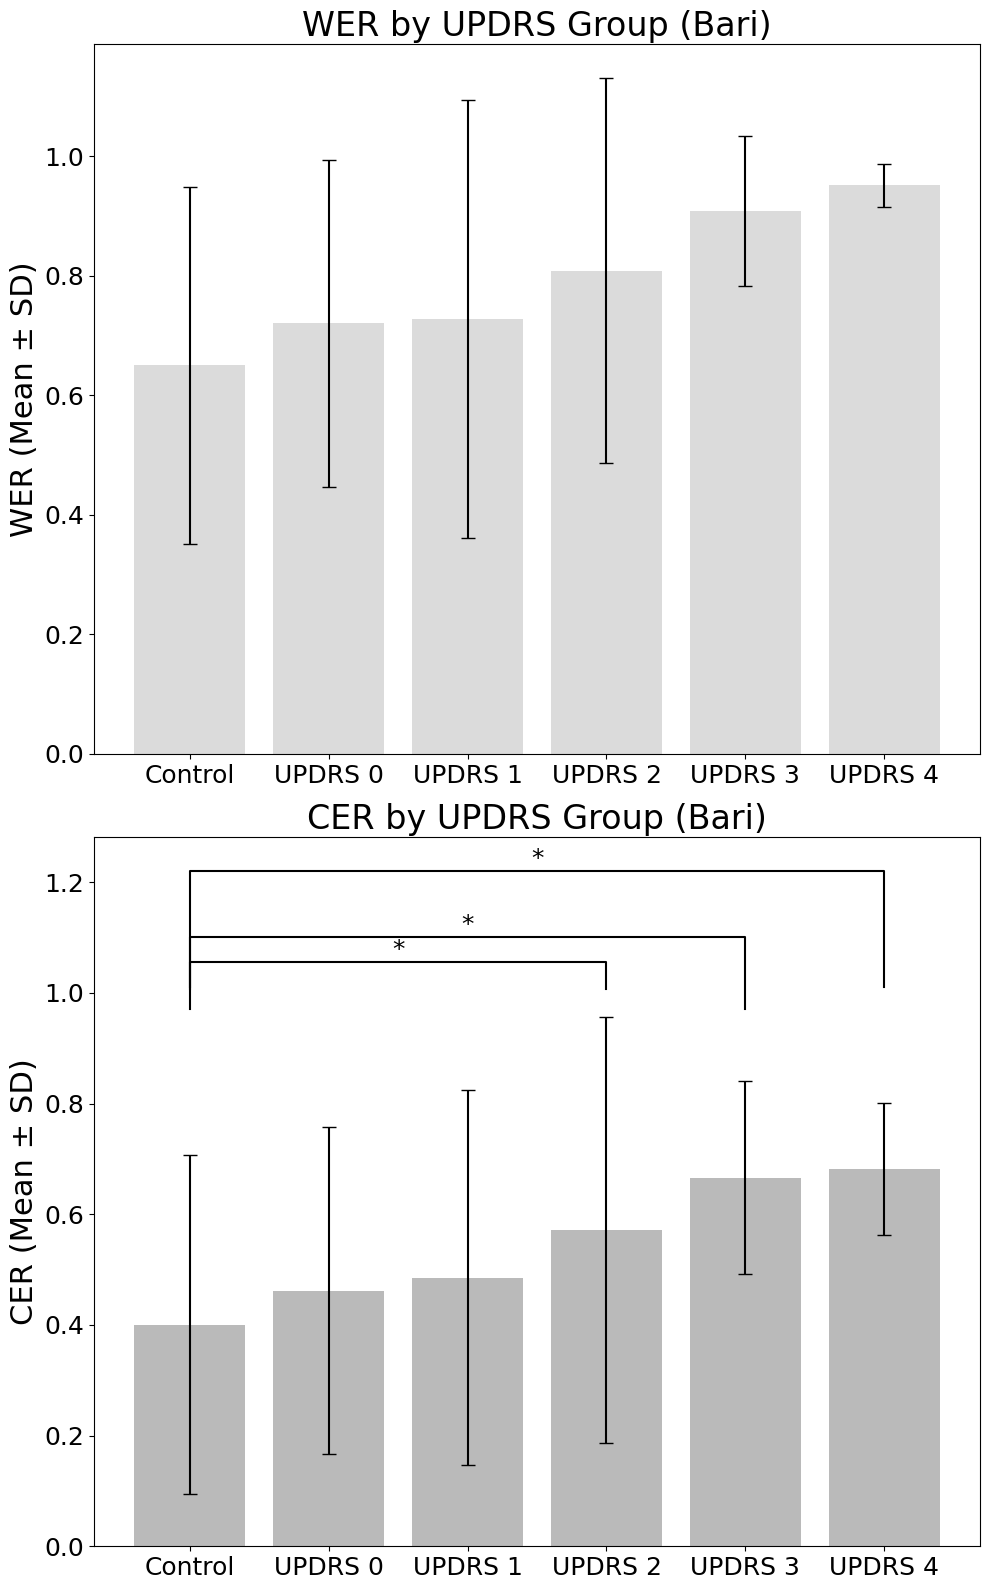

✅ Figure saved as 'baristatistics.pdf' and displayed.


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_significance_adjusted(wer_df, cer_df, dunn_results, updrs_levels):
    """
    Generates bar plots for WER and CER across UPDRS groups,
    showing only statistically significant differences based on Dunn's post hoc test.
    The figure is saved as a high-quality PDF and also displayed.
    """

    # Extract WER and CER means and standard deviations
    wer_means = wer_df['WER Mean'].values
    wer_stds = wer_df['WER Std Dev'].values
    cer_means = cer_df['CER Mean'].values
    cer_stds = cer_df['CER Std Dev'].values

    x_positions = np.arange(len(updrs_levels))

    def add_significance(ax, x1, x2, y, p_value, line_offset=0):
        """Adds a significance bar with asterisk annotation between x1 and x2 if p-value is significant."""
        if p_value < 0.05:
            if p_value < 0.0001:
                symbol = '****'
            elif p_value < 0.001:
                symbol = '***'
            elif p_value < 0.01:
                symbol = '**'
            else:
                symbol = '*'
            ax.plot([x1, x1, x2, x2], [y, y + line_offset, y + line_offset, y],
                    color='black', linewidth=1.5)
            ax.text((x1 + x2) * 0.5, y + line_offset, symbol,
                    ha='center', va='bottom', color='black', fontsize=18)  # back to original size

    # Create a figure with two vertical subplots (WER and CER)
    fig, axes = plt.subplots(2, 1, figsize=(10, 16))

    # Plot WER
    axes[0].bar(x_positions, wer_means, yerr=wer_stds, capsize=5,
                color='lightgray', alpha=0.8)
    axes[0].set_title('WER by UPDRS Group (Bari)', fontsize=24)
    axes[0].set_xticks(x_positions)
    axes[0].set_xticklabels(updrs_levels, fontsize=18)
    axes[0].tick_params(axis='y', labelsize=18)
    axes[0].set_ylabel('WER (Mean ± SD)', fontsize=22)

    # Plot CER
    axes[1].bar(x_positions, cer_means, yerr=cer_stds, capsize=5,
                color='darkgray', alpha=0.8)
    axes[1].set_title('CER by UPDRS Group (Bari)', fontsize=24)
    axes[1].set_xticks(x_positions)
    axes[1].set_xticklabels(updrs_levels, fontsize=18)
    axes[1].tick_params(axis='y', labelsize=18)
    axes[1].set_ylabel('CER (Mean ± SD)', fontsize=22)

    # Add significance bars to CER plot
    if dunn_results:
        cer_significance = dunn_results[0][1]
        pairs = [(i, j) for i in range(len(updrs_levels)) for j in range(i + 1, len(updrs_levels))]
        line_offset = 0.05
        for (i, j) in pairs:
            p_value = cer_significance.iloc[i, j]
            if p_value < 0.05:
                y = max(cer_means[i] + cer_stds[i], cer_means[j] + cer_stds[j]) + line_offset
                add_significance(axes[1], i, j, y, p_value, line_offset)
                line_offset += 0.08  # Increment height for next bar

    plt.tight_layout()

    # Save the figure as a high-quality PDF
    fig.savefig("/Users/benedettaperrone/Documents/TESI/TESI SCRITTA/Paper/Figures/baristatistics.pdf",
                format='pdf', bbox_inches='tight')

    # Display the plot
    plt.show()

    print("✅ Figure saved as 'baristatistics.pdf' and displayed.")

    
plot_with_significance_adjusted(
    wer_df,
    cer_df,
    dunn_results,
    updrs_levels=['Control', 'UPDRS 0', 'UPDRS 1', 'UPDRS 2', 'UPDRS 3', 'UPDRS 4']
)


In [28]:
print(parkinsonian_wer_clean)
print(len(parkinsonian_wer_clean))

print(parkinsonian_wer)
len(parkinsonian_wer)

[0.96875, 1.0, 0.96875, 0.4921875, 0.4453125, 0.9609375, 0.9609375, 0.2890625, 0.953125, 0.3828125, 1.421875, 0.4609375, 0.984375, 0.546875, 0.9609375, 0.3046875, 0.9921875, 1.0, 1.0, 0.9140625, 1.0, 0.4375, 0.4609375, 0.9609375, 0.9609375, 0.953125, 0.609375, 0.9609375, 1.0, 0.5390625, 0.9296875, 0.2890625, 0.4921875, 0.4296875, 0.3984375, 0.4296875, 0.5625, 1.0, 0.9609375, 0.390625, 1.0, 0.96875, 1.0, 1.0, 0.953125, 0.2890625, 0.34375, 0.40625, 1.0, 0.265625, 0.4140625, 0.9609375, 1.0, 1.3984375, 0.96875, 0.9609375, 0.9609375, 1.0, 0.4453125, 0.9921875, 1.0, 0.3203125, 0.375, 0.9609375, 1.0, 0.40625, 0.40625, 0.828125, 0.5234375, 0.9609375, 0.46875, 0.984375, 1.0, 0.9609375, 1.0, 1.0, 0.3671875, 0.9609375, 0.484375, 1.0, 0.9921875, 0.3125, 0.953125, 0.7109375, 0.9609375, 1.0, 0.4140625, 0.4140625, 0.328125, 0.6328125, 1.0, 1.0, 0.5078125, 0.5546875, 0.328125, 0.9609375, 0.5546875, 0.3515625, 0.5, 0.9609375, 0.96875, 0.765625, 0.9609375, 0.3828125, 0.359375]
105
[0.96875, 1.0, 0.96875

106